In [4]:
import pandas as pd


In [5]:
Train            = pd.read_csv(BASE_DIR+'cgiar-crop-damage-classification-challenge/Train.csv')
Test             = pd.read_csv(BASE_DIR+'cgiar-crop-damage-classification-challenge/Test.csv')
SampleSubmission = pd.read_csv(BASE_DIR+'cgiar-crop-damage-classification-challenge/SampleSubmission.csv')
Train = Train[Train['damage'] != 'ND']
Train = Train[Train['damage'] != 'other']

In [6]:
Train.head()

,ID,damage,filename
0,ID_UBHORS,WD,d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg
1,ID_9DSOLZ,G,9ea16180c50d0cd539897eefbfe585314e50a56b.jpg
2,ID_JHLM0G,G,b6b564844041bc68774a553eaf43d61654657dd9.jpg
3,ID_ATREIJ,DR,62262859f0cd411aaf484082ed3ef0b625bc452a.jpg
4,ID_L2GAD6,G,03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg


In [7]:
Train.damage.value_counts(),Train.count()

(G     11623
 WD     9238
 DR     4516
 Name: damage, dtype: int64,
 ID          25377
 damage      25377
 filename    25377
 dtype: int64)

In [8]:
Test.head(),Test.count()

(          ID                                      filename
 0  ID_QW9GQM  03428805a0d7d269b422dbfafb3f86cb394a0491.jpg
 1  ID_G9VPQ9  5dcf4f5d82708496ad7c3227ccbc8af5058aa227.jpg
 2  ID_QIMIEM  4e835aa40e4aafa24db13cba4182094eb9e5eb79.jpg
 3  ID_TSINUQ  1e0dbb8669385be73a480ce108d12bdc4354f120.jpg
 4  ID_I7OOHH  3d05e31502f9f00ce25770666c73af5f323a8b3a.jpg,
 ID          8663
 filename    8663
 dtype: int64)

In [9]:
Test.value_counts()

ID         filename                                    
ID_00131R  b6db4273a8ccbd10baec9a934fd99670961f1e13.jpg    1
ID_O2NKQG  8c306c0a4656f9dbc474bbf23dc65ccd1f880379.jpg    1
ID_O4VJQX  c66a2e776b11ee1af7b485ae49618b92c7534582.jpg    1
ID_O4SLAL  fb39c670af6339e74b87fe9a199a0b4b33e94cb9.jpg    1
ID_O4E311  1a77d096f24a9225696d75f6050d330bbe28cfc4.jpg    1
                                                          ..
ID_BVRNBL  be902cacbbbe55142e37761a61ae65876ef409ee.jpg    1
ID_BVRCGE  d448b2171896504f53453f402d7240c1809c4014.jpg    1
ID_BVNXSJ  85dcb111bc3fa1db98ac81a36121007c7cbeece4.jpg    1
ID_BVBSON  751da8b794180a24bc89ed56bc3d8f94bfe7adc7.jpg    1
ID_ZZXQ33  99c74a1100cc5a1c208c4f677d4ed35e9c7a18eb.jpg    1
Length: 8663, dtype: int64

In [11]:
damage = Train.damage.unique()

In [13]:
damage

array(['WD', 'G', 'DR'], dtype=object)

In [14]:
import tensorflow as tf
from keras import Sequential, Model
from keras.activations import softmax
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D,LeakyReLU

In [15]:
labels_train = Train.iloc[:, 2]
filenames_train = Train.iloc[:, -1]
# labels_test = Test.iloc[:, 2]
filenames_test = Test.iloc[:, -1]
# Test.head()

In [16]:
n=len(damage)
n

3

In [17]:
data_dir = BASE_DIR+'cgiar-crop-damage-classification-challenge/images/images/'

In [18]:
import cv2
def preprocess_input(img):
   img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
   return img
train_datagen = ImageDataGenerator(
                                    # rescale=1./255,
                                   # preprocessing_function=tf.keras.applications.xception.preprocess_input,
                                  preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
                                  rotation_range=10,
                                  width_shift_range = 0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  validation_split=0.15)

train_generator = train_datagen.flow_from_dataframe(
   dataframe=Train,
   directory=data_dir,
   x_col='filename',
   y_col='damage',
   target_size=(256, 256),
   class_mode='categorical',
   subset='training',
   shuffle=False,
   batch_size=32)

validation_generator = train_datagen.flow_from_dataframe(
   dataframe=Train,
   directory=data_dir,
   x_col='filename',
   y_col='damage',
   target_size=(256, 256),
   class_mode='categorical',
   subset='validation',
   shuffle=False,
   batch_size=32)


Found 21568 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 3806 validated image filenames belonging to 3 classes.


In [19]:
submission_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_dataframe(
   dataframe=Test,
   directory=data_dir,
   target_size=(256, 256),
   shuffle=False,
   batch_size=32,
   class_mode=None # No labels
)

Found 8663 validated image filenames.


In [20]:
submission_generator

In [21]:
validation_generator.class_indices

{'DR': 0, 'G': 1, 'WD': 2}

In [22]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(256, 256, 3)) # 224 224 3
# base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(512,activation='relu'))
# model.add(LeakyReLU(alpha=0.2))
model.add(Dense(n, activation="softmax" , name="classification"))

17225924/17225924 [==============================] - 0s 0us/step


In [23]:
model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.0007,momentum=0.9),
            # optimizer=tf.keras.optimizers.Adam(amsgrad=True),
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 3)                 1

In [24]:
logdir = BASE_DIR+'log'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [27]:
checkpoint_filepath=BASE_DIR+'weights/crop_damage_classification_best_model_withProcessing.hdf5'

In [ ]:
# model.load_weights(checkpoint_filepath)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint=ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             save_freq='epoch',
                             mode='min')

In [29]:
history = model.fit(train_generator, validation_data = validation_generator, epochs = 15, callbacks=[tensorboard_callback, early_stopping,model_checkpoint])

Epoch 1/15
674/674 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.6271 
Epoch 1: val_loss improved from inf to 0.67980, saving model to drive/MyDrive/kaggle/weights/crop_damage_classification_best_model_withProcessing.hdf5
674/674 [==============================] - 8160s 12s/step - loss: 0.7942 - accuracy: 0.6271 - val_loss: 0.6798 - val_accuracy: 0.6931
Epoch 2/15
674/674 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.7030
Epoch 2: val_loss improved from 0.67980 to 0.66340, saving model to drive/MyDrive/kaggle/weights/crop_damage_classification_best_model_withProcessing.hdf5
674/674 [==============================] - 801s 1s/step - loss: 0.6686 - accuracy: 0.7030 - val_loss: 0.6634 - val_accuracy: 0.6978
Epoch 3/15
674/674 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.7194
Epoch 3: val_loss improved from 0.66340 to 0.64473, saving model to drive/MyDrive/kaggle/weights/crop_damage_classification_best_model_with

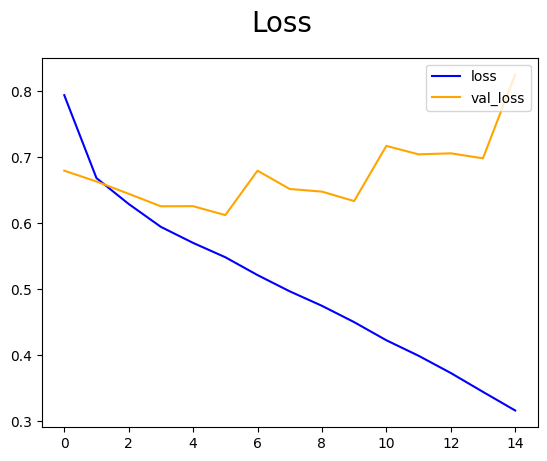

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle("Loss", fontsize=20)
plt.legend(loc='upper right')
plt.show()

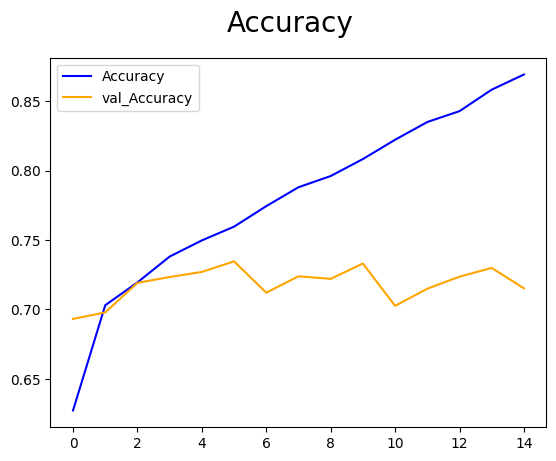

In [32]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_Accuracy')
fig.suptitle("Accuracy", fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [33]:
predictions=model.evaluate_generator(validation_generator, 32)
print(predictions)

<ipython-input-33-4c9399092695>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  predictions=model.evaluate_generator(validation_generator, 32)


[0.8390393853187561, 0.68359375]


In [34]:
import matplotlib.pyplot as plt
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)


<ipython-input-36-55a6b2211154>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator)


Confusion Matrix
Normalized confusion matrix


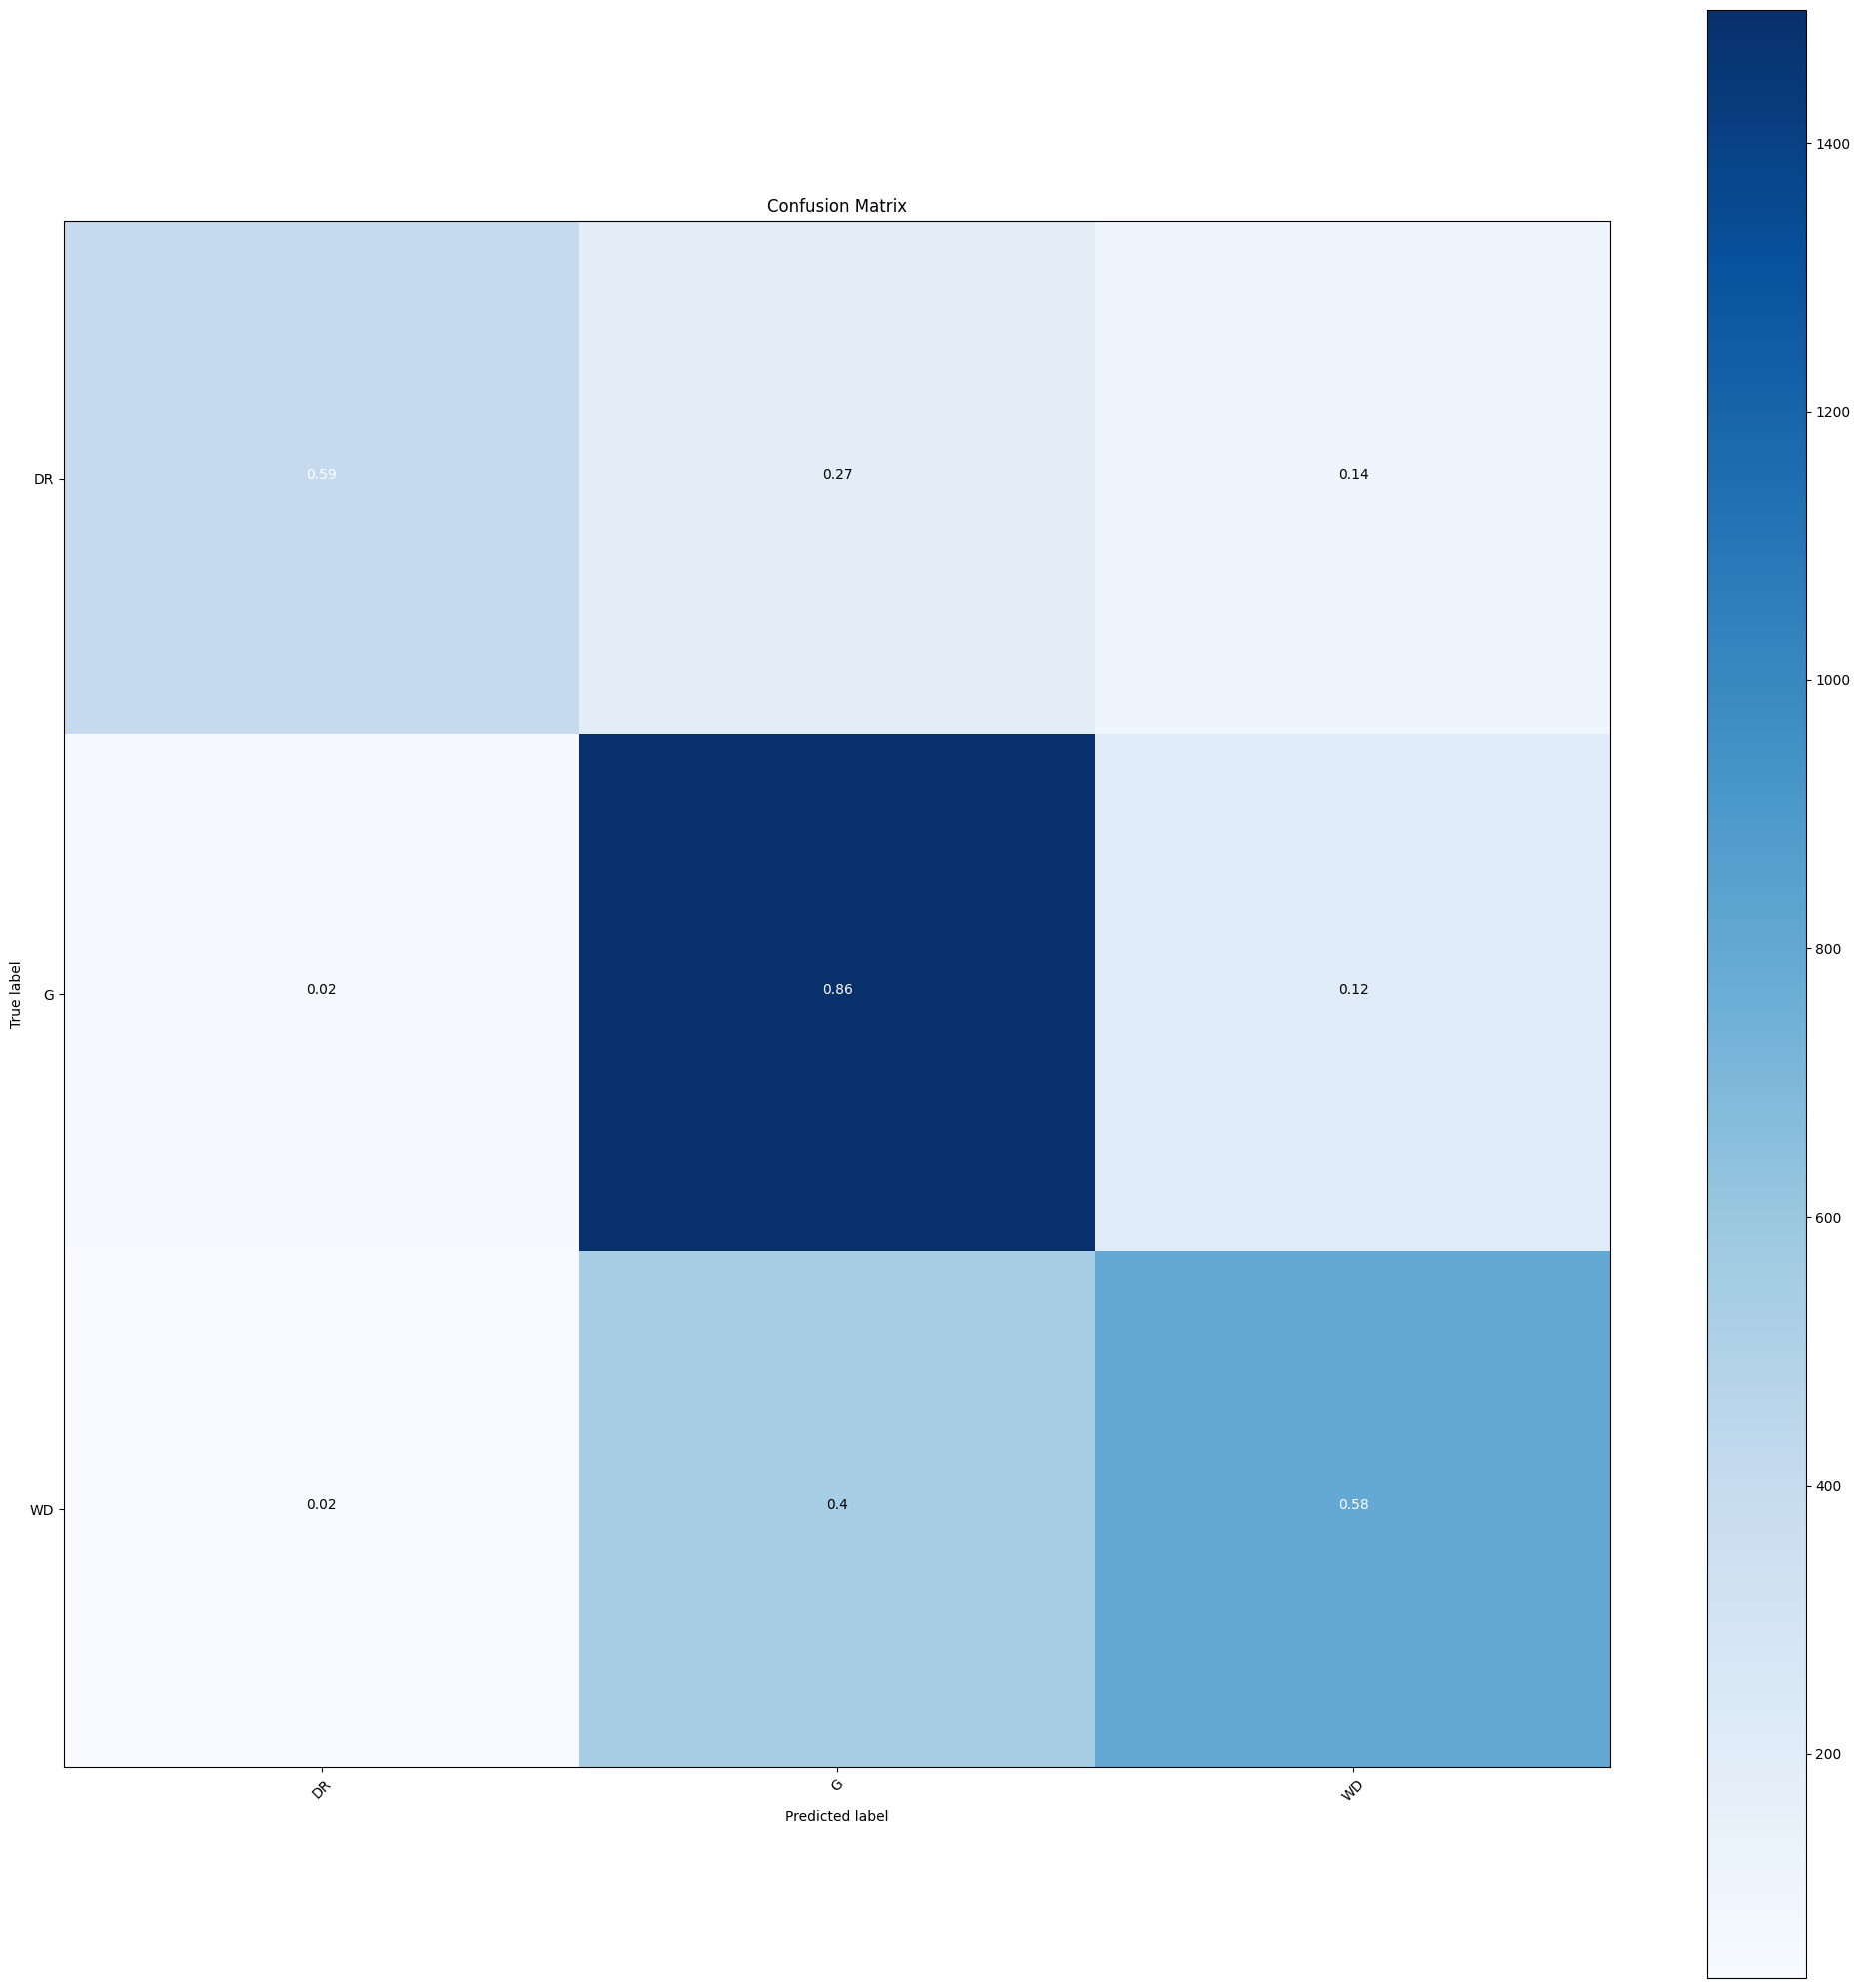

In [36]:
import numpy as np
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

In [37]:
#Print Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

          DR       0.84      0.59      0.69       684
           G       0.67      0.86      0.75      1752
          WD       0.72      0.58      0.64      1370

    accuracy                           0.71      3806
   macro avg       0.74      0.67      0.70      3806
weighted avg       0.72      0.71      0.70      3806

